In [1]:
from pathlib import Path

import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

2024-07-04 11:59:28.763613: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 11:59:28.789484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 11:59:28.789516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 11:59:28.789538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 11:59:28.794689: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 11:59:28.796001: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
train_ds, val_ds = tfds.load('svhn_cropped', split=['train[:80%]', 'train[80%:]'])
test_ds = tfds.load('svhn_cropped', split='test')
len(train_ds), len(val_ds), len(test_ds)

(58606, 14651, 26032)

(<matplotlib.image.AxesImage at 0x755fe0706990>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>)

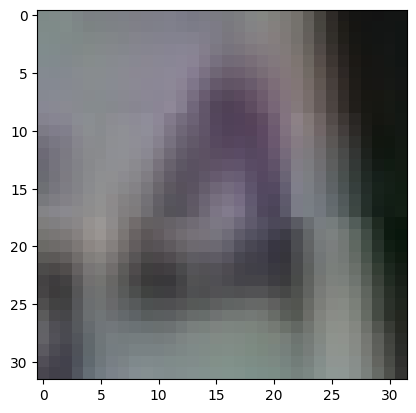

In [3]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [4]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.3, value_range=(0.,1.)),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.RandomRotation(factor=(-0.3,0.3))

])

In [5]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['label']
        image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            # .repeat(3)
            # .map(lambda x, y: (augmentation(x), y))  # augmentation doesn't really help
            .batch(512)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(512)
        )

In [6]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

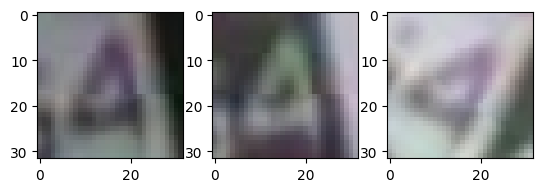

In [7]:
img = next(iter(train_ds))['image']
augmented_img = augmentation(tf.cast(img, dtype=tf.float32) / 255.)
fig, axes = plt.subplots(1,3)
axes[0].imshow(img)
axes[1].imshow(tf.image.adjust_contrast(img, -1.1))
axes[2].imshow(augmented_img)

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10),
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer, 
    loss=loss_object, 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

In [9]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10


115/115 [==============================] - 23s 193ms/step - loss: 2.1568 - accuracy: 0.2285 - val_loss: 1.7263 - val_accuracy: 0.4632
Epoch 2/10
115/115 [==============================] - 21s 186ms/step - loss: 1.2417 - accuracy: 0.6082 - val_loss: 0.8123 - val_accuracy: 0.7785
Epoch 3/10
115/115 [==============================] - 21s 185ms/step - loss: 0.8025 - accuracy: 0.7615 - val_loss: 0.6405 - val_accuracy: 0.8205
Epoch 4/10
115/115 [==============================] - 22s 190ms/step - loss: 0.6692 - accuracy: 0.8033 - val_loss: 0.5547 - val_accuracy: 0.8460
Epoch 5/10
115/115 [==============================] - 22s 188ms/step - loss: 0.5995 - accuracy: 0.8229 - val_loss: 0.5194 - val_accuracy: 0.8573
Epoch 6/10
115/115 [==============================] - 22s 187ms/step - loss: 0.5582 - accuracy: 0.8344 - val_loss: 0.4837 - val_accuracy: 0.8644
Epoch 7/10
115/115 [==============================] - 22s 189ms/step - loss: 0.5219 - accuracy: 0.8448 - val_loss: 0.4585 - val_accuracy: 0.8

In [10]:
model.evaluate(test)

51/51 [==============================] - 2s 33ms/step - loss: 0.4780 - accuracy: 0.8643


[0.4779702126979828, 0.8643208146095276]

Text(0.5, 1.0, 'Accuracy on SVHN')

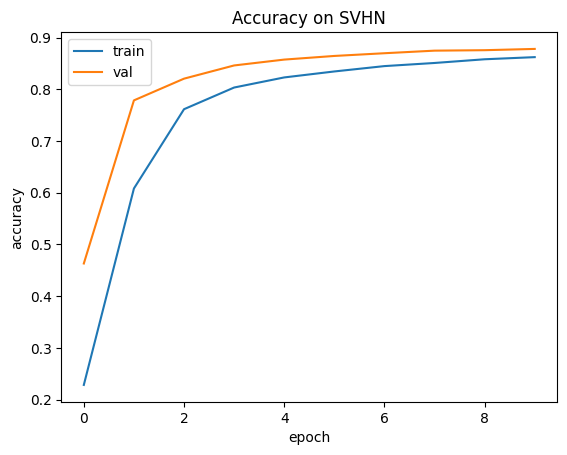

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy on SVHN')